# Algorithm Performance Profile

This notebook produces an algorithm profile following an experiment with `doframework`.

We retrieve all solutions and analyze their performance.

In [1]:
import os
import yaml
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

from doframework.core.storage import Storage
from doframework.core.inputs import get_configs
from doframework.core.gp import find_modal
from doframework.flow.metrics import files_from_solution

# Configs

Get storage configurations from your `configs` file, located in your `HOME` directory.

In [2]:
configs_root = os.environ['HOME']
configs_file = 'ibm_configs.yaml'
configs_path = os.path.join(configs_root,configs_file)

configs = get_configs(configs_path)

# Storage

In [3]:
storage = Storage(configs)

In [4]:
buckets = storage.buckets()

You can limit the number of file to fetch by adding `limit=10` to `get_all`.

In [5]:
solution_files = storage.get_all(buckets['solutions'],'json')

# Problem Type

We choose which problems to analyze: either minimum or maximum.

In [6]:
opt = 'min'

# Fetch Results

Fetching all results may take time, if using `S3`, depending on network.

In [7]:
rel_perfs = []

for file in solution_files:
    
    solution_name = file.key if 's3' in configs else file.name
    
    solution_obj = storage.get(buckets['solutions'],solution_name)
    solution = json.load(solution_obj)
            
    assoc_files = files_from_solution(solution_name)
    objective_name = assoc_files['objective']
    data_name = assoc_files['data']
    
    # get relevant objective
    objective_obj = storage.get(buckets['objectives_dest'],objective_name)
    objective = json.load(objective_obj)    
    dim = len(objective['optimum'][opt]['arg'])
            
    if solution['solution'][opt] != 'FAILED':
        
        solution_val = solution['solution'][opt]['value']
        true_min_val = objective['optimum']['min']['value']
        true_max_val = objective['optimum']['max']['value']

        rel_perf = (solution_val-true_min_val)/(true_max_val-true_min_val)
        rel_perfs.append([solution_name,objective_name,data_name,dim,rel_perf,True])
        
    else:
        
        rel_perfs.append([solution_name,objective_name,data_name,dim,np.nan,False])        
            

# Performance

In [8]:
df = pd.DataFrame(rel_perfs,columns=['solution','objective','data','dimension','performance','success'])

In [9]:
df[['solution','dimension','performance','success']].head()

,solution,dimension,performance,success
0,solution_00n7ij1v_1cvhizdl_vi305l04.json,5,0.569573,True
1,solution_00n7ij1v_mprc0vvq_ip6vu5fd.json,5,0.531534,True
2,solution_03h5bdk9_3hd7z5xo_ivoq4jyp.json,7,0.383707,True
3,solution_03h5bdk9_4ntc4wxh_5y44wmcm.json,7,0.282968,True
4,solution_03h5bdk9_bsm1g70l_g3d4bbjq.json,7,0.199511,True


In [10]:
solution_num = df.shape[0]
solution_good = df[~df.performance.isna()].shape[0]

print('Reviewed {} solutions.'.format(solution_num))
print('Of those, {:.2f}% succsessful.'.format(100*(solution_good/solution_num)))

Reviewed 651 solutions.
Of those, 94.47% succsessful.


# Profile

Let's see how performance scores are distributed.

The score of a predicted optimum $\hat{x}^*$ relative to the true optimum is

$$\text{score}(\hat{x}^*) = \frac{f(\hat{x}^*)-f(x_\min)}{f(x_\max)-f(x_\min)}$$

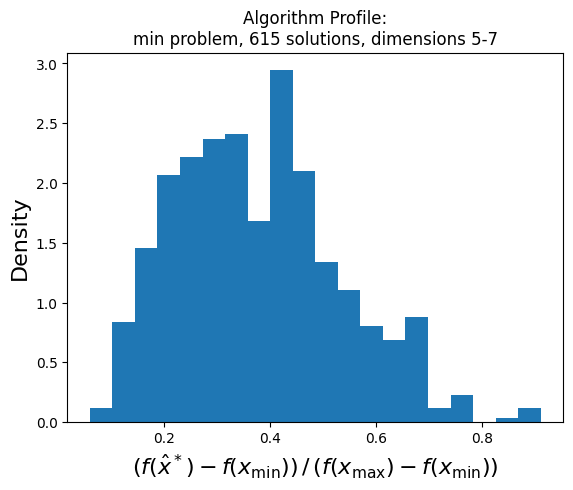

In [11]:
plt.hist(df.performance,density=True,bins=20)
plt.title('Algorithm Profile:\n{} problem, {} solutions, dimensions {}-{}'.\
          format(opt,solution_good,min(df.dimension),max(df.dimension)))
plt.xlabel(r'$(f(\hat{x}^*)-f(x_\min))\,/\,(f(x_\max)-f(x_\min))$',fontsize=16)
plt.ylabel(r'Density',fontsize=16)
plt.show()

In [12]:
print('Mean Performance: {:.2f}'.format(df.performance.mean()))
print('Median Performance: {:.2f}'.format(df.performance.median()))
print('Distribution Modal: {:.2f}'.format(find_modal(df[~df.performance.isna()].performance)[0]))

Mean Performance: 0.38
Median Performance: 0.36
Distribution Modal: 0.41


# Probability

Estimate the probability 
$$Pr[f(\hat{x}^*) - f(x_{\min})<  \epsilon \cdot (f(x_{\max})-f(x_{\min}))]$$
for an algorithm predicted optimum $\hat{x}^*$ of $f$ in $\Omega$.

In [13]:
kde = gaussian_kde(df[~df.performance.isna()].performance)

epsilon = 0.4

print('Estimated performance probability: {:.2f}'.format(kde.integrate_box_1d(0,epsilon)))

Estimated performance probability: 0.58
